In [1]:
import numpy as np
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve

# Solve the following initial value problem (forward Euler)

$$\frac{dy}{dt} = -\alpha y; \quad\quad y(0) = y_0$$

The analytical solution is:

$$ y(t) = y_0e^{-\alpha t} $$

In [167]:
# Define the RHS
α = 500.0
def rhs_sharp_transient(f, t):
    return - α * f

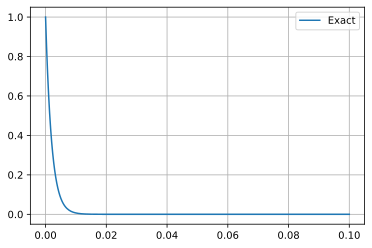

In [168]:
# Plot the exact solution
yexact = lambda y0, a, t: y0*np.exp(-a*t)
t = np.linspace(0, 0.1, 300)
y0 = 1
plt.plot(t, yexact(y0, α, t), label='Exact')
plt.grid()
plt.legend()

In [171]:
# Attempt solution with Forward Euler
def forward_euler(rhs, tend, dt, y0):
    nsteps = int(tend/dt)
    f = np.empty(nsteps)
    t = np.linspace(0, tend, nsteps)
    f[0] = y0
    for n in range(1, nsteps):
        f[n] = f[n-1] + dt * rhs(f[n-1], t[n-1])
    return f, t

In [178]:
tend = 0.1
dt = 0.0045
if dt >= (2/α):
    print(f'Warning: dt size will cause instability')
else:
    print(f'dt is less than {2/α}. Solution will be stable')
yfe, t = forward_euler(rhs_sharp_transient, tend, dt, y0)

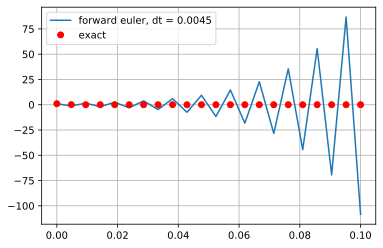

In [179]:
plt.plot(t, yfe, label=f'forward euler, dt = {dt}')
plt.plot(t, yexact(y0, α, t), 'ro', label='exact')
plt.grid()
plt.legend()

There are stability conditions that must be imposed on the timestep size in order to prevent instability from occurring in the solution. Implicit methods avoid this complication by incorporating information from the future into the solution:

$$\frac{d\phi }{dt} \bigg|_{n+1}\  =\  R(t_{n+1},\  \phi_{n+1} )$$

To solve this implicitly, we solve the residual form of the equation, with Newton's Method, at each timestep.

## Solution using backward Euler

In [180]:
def be_residual(fnp1, fn, rhs, dt, tnp1):
    return fnp1 - fn - dt*rhs(fnp1, tnp1)

def backward_euler(rhs, f0, tend, dt):
    nsteps = int(tend/dt)
    f = np.zeros(nsteps)
    f[0] = f0
    time = np.linspace(0, tend, nsteps)
    for n in np.arange(nsteps-1):
        fn = f[n]
        tnp1 = time[n+1]
        fnew = fsolve(be_residual, fn, args=(fn, rhs, dt, tnp1))
        f[n+1] = fnew
    return time, f

In [181]:
f0 = 1.
tend = 0.1
dt = 0.003

t, fbe = backward_euler(rhs_sharp_transient, f0, tend, dt)

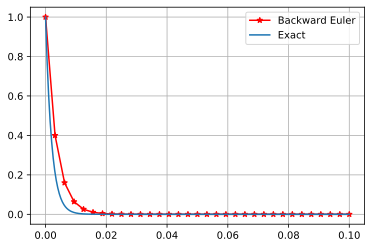

In [182]:
plt.plot(t, fbe, 'r*-', label='Backward Euler')
texact = np.linspace(0, tend, 400)
plt.plot(texact, yexact(f0, α, texact), label='Exact')
plt.grid()
plt.legend()

# Manual implementation of Newton's Method

Let's do it, just to see if we can.

In [183]:
def implicit_newton(f, df, x0, tol, maxiter, *args):
    err = 100
    niter = 0
    fnp1 = x0
    while err > tol:
        fnew = fnp1 - f(fnp1, *args)/df(f, fnp1, *args)
        err = np.abs(f(fnew, *args))
        fnp1 = fnew
        niter += 1
        #print(f'Steps: {niter}, err: {err:.6e}')
    return fnew

In [184]:
def implicit_df(f, fnp1, *args):
    h = 1e-6
    return (f(fnp1+h, *args) - f(fnp1, *args))/h

In [192]:
implicit_newton(be_residual, implicit_df, 15, 1e-12, 100, 1., rhs_sharp_transient, 0.0005, 0.0005)

0.8

In [193]:
f0 = 100
tend = 0.1
dt = 0.002
def backward_euler_manual(rhs, f0, tend, dt):
    nsteps = int(tend/dt)
    f = np.zeros(nsteps)
    f[0] = f0
    fnew = 10
    time = np.linspace(0, tend, nsteps)
    for n in np.arange(nsteps-1):
        fn = f[n]
        tnp1 = time[n+1]
        fnew = implicit_newton(be_residual, implicit_df, fnew, 1e-3, 100, fn, rhs, dt, tnp1)
        f[n+1] = fnew
    return time, f

In [194]:
time, fmanual = backward_euler_manual(rhs_sharp_transient, f0, tend, dt)

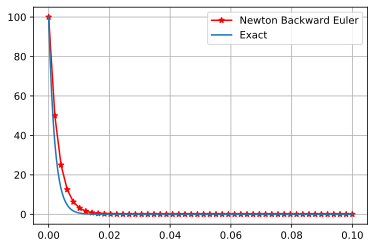

In [195]:
plt.plot(time, fmanual, 'r*-', label='Newton Backward Euler')
texact = np.linspace(0, tend, 400)
plt.plot(texact, yexact(f0, α, texact), label='Exact')
plt.grid()
plt.legend()

## Using ODEINT

In [189]:
time = np.linspace(0, 0.1, 20)
sol = odeint(rhs_sharp_transient, f0, time)

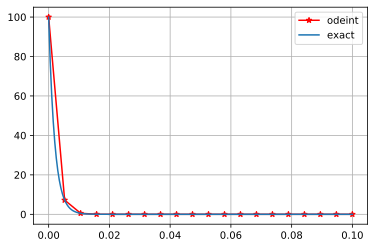

In [191]:
plt.plot(time, sol, 'r*-', label='odeint')
plt.plot(texact, yexact(f0, α, texact), label='exact')
plt.grid()
plt.legend()

## Using ODEINT for a series of ODEs

$$\frac{dS}{dt} =-\frac{\beta}{N} IS$$
$$\frac{dI}{dt} =\frac{\beta}{N} IS-\gamma I$$
$$\frac{dR}{dt} =\gamma I$$

In [196]:
def rhs_sir(SIR, t, N, beta, gamma):
    S, I, R = SIR     # vector of solutions
    dSdt = -beta/N*I*S
    dIdt = beta/N*I*S - gamma*I
    dRdt = gamma*I
    
    return dSdt, dIdt, dRdt

In [202]:
N = 3e3     # total population
I0 = 10     # Initial sick people
R0 = 0      # 0 recovered initially
S0 = N - I0 # Conserve entire population (non-infected)
β = 0.6
γ = 1/14.0  # Inverse of recovery rate

tend = 100  # days
t = np.linspace(0, tend, tend)
# Initial condition vector
y0 = S0, I0, R0
# Integrate SIR equations over the time grid
sol = odeint(rhs_sir, y0, t, args=(N, β, γ))
S, I, R = sol.T

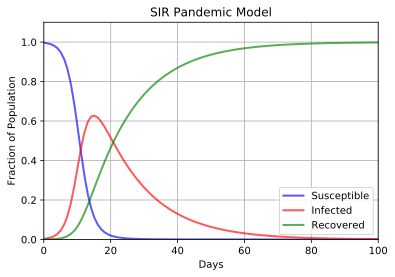

In [203]:
plt.plot(t, S/N, 'b', alpha=0.65, lw=2, label='Susceptible')
plt.plot(t, I/N, 'r', alpha=0.65, lw=2, label='Infected')
plt.plot(t, R/N, 'g', alpha=0.65, lw=2, label='Recovered')
plt.xlabel('Days')
plt.ylabel('Fraction of Population')
plt.xlim([0, tend])
plt.ylim([0, 1.1])
plt.legend()
plt.title('SIR Pandemic Model')
plt.grid()

# Solving SIR without ODEINT!

This was a tough one to wrap my brain around, but I got it working using implicit forward Euler. Would it have been easier to solve explicitly? Yes. But, this way was more reqarding and I get the added benefit of unconditional stability.

In [265]:
def sir_implicit(SIRnp1, SIRn, rhs, dt, *args):
    return SIRnp1 - SIRn - dt*rhs(SIRnp1, *args)

In [267]:
def jacobian(funcs, vars_, *args):
    h = 1e-6
    return (funcs(vars_+h, *args) - funcs(vars_, *args))/h

In [268]:
def newton_implicit_series(implicit_funcs, derivative_func, tol, y0, implicit_funcs_args):
    err = 100
    niter = 0
    #fold = y0
    if not isinstance(y0, np.ndarray):
        fnp1 = np.array(y0)
    else:
        fnp1 = y0
    while err > tol:
        Fvals = implicit_funcs(fnp1, *implicit_funcs_args)
        Jvals = derivative_func(implicit_funcs, fnp1, *implicit_funcs_args)
        fnew = fnp1 - Fvals/Jvals
        fnp1 = fnew
        err = np.linalg.norm(Fvals)
        niter += 1
    return fnew

In [280]:
# *args = N, beta, gamma
N = 3e3     # total population
I0 = 10     # Initial sick people
R0 = 0      # 0 recovered initially
S0 = N - I0 # Conserve entire population (non-infected)
β = 0.2
γ = 1/14.0  # Inverse of recovery rate
tend = 100  # days
t = np.linspace(0, tend, tend)
dt = 1
# Initial condition vector
y0 = S0, I0, R0

def backward_euler_series(rhs, f0, tend, dt, *args):
    nsteps = int(tend/dt)
    f = np.zeros((nsteps, len(f0)))
    f[0,:] = f0
    fnew = f0
    time = np.linspace(0, tend, nsteps)
    for n in np.arange(nsteps-1):
        fn = f[n]
        implicit_args = [fn, rhs, dt, *args]
        tnp1 = time[n+1]
        fnew = newton_implicit_series(sir_implicit, jacobian, 1e-3, fnew, implicit_args)
        f[n+1] = fnew
    return time, f

In [281]:
t, sol = backward_euler_series(rhs_sir, np.array(y0), tend, dt, t, N, β, γ)

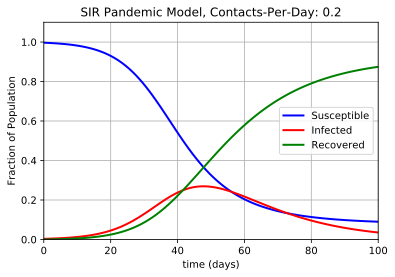

In [282]:
plt.plot(t, sol.T[0]/N, lw=2, c='b', label='Susceptible')
plt.plot(t, sol.T[1]/N, lw=2, c='r', label='Infected')
plt.plot(t, sol.T[2]/N, lw=2, c='g', label='Recovered')
plt.title(f'SIR Pandemic Model, Contacts-Per-Day: {β}')
plt.ylim([0,1.1])
plt.xlim([0, tend])
plt.xlabel('time (days)')
plt.ylabel('Fraction of Population')
plt.grid()
plt.legend()
plt.savefig('SIR_solution_beta2.png', dpi=300)

# Pendulum ODE by reduction of order

$$\theta^{\prime \prime } (t)\  +\  \theta (t)\  =\  0$$
$$y_{1}\  =\  \theta(t)$$
$$y_{2}\  =\  y^{\prime }_{1}=\theta^{\prime} (t)$$
$$y^{\prime }_{2}\  =\  \theta^{\prime\prime} (t)\  =\  -y_{1}$$
$$y^{\prime}_2 = -y_1$$
$$y^{\prime}_1 = y_2$$

In [294]:
def pendulum_rhs(y, t):
    dy = np.zeros_like(y)
    dy = [y[1], -y[0]]
    return np.asarray(dy)

def euler(func, y0, t):
    y = np.zeros((np.size(t), np.size(y0)))
    y[0, :] = y0
    
    for i in range(len(t)-1):
        dt = t[i+1] - t[i]
        y[i+1, :] = y[i,:] + dt*func(y[i,:], t[i])
    return y

In [304]:
N = 500
time = np.linspace(0, 2*np.pi, N+1)
theta0 = [0.1, 0.]

theta = euler(pendulum_rhs, theta0, time)
theta_exact = theta0[0]*np.cos(time)

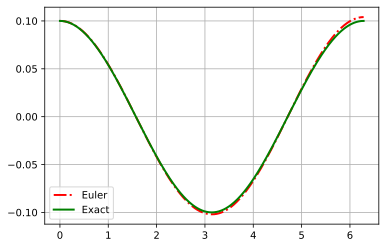

In [310]:
plt.plot(time, theta[:,0],'r-.', lw=2,label='Euler')
plt.plot(time, theta_exact,'g',lw=2, label='Exact')
plt.grid()
plt.legend()

In [312]:
theta_odeint = odeint(pendulum_rhs, theta0, time)

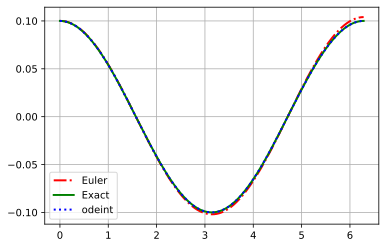

In [314]:
plt.plot(time, theta[:,0],'r-.', lw=2,label='Euler')
plt.plot(time, theta_exact, 'g', lw=2,label='Exact')
plt.plot(time, theta_odeint[:,0], 'b:', lw=2,label='odeint')
plt.grid()
plt.legend()

# Interactive pandemic solution

In [315]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [337]:
N = 3e3     # total population
#I0 = 10     # Initial sick people
R0 = 0      # 0 recovered initially
#S0 = N - I0 # Conserve entire population (non-infected)
#β = 0.6
#γ = 1/14.0  # Inverse of recovery rate
#SIR0 = S0, I0, R0
tend = 100  # days
t = np.linspace(0, tend, tend)

def plot_pandemic(β, γ, I0):
    S0 = N - I0
    SIR0 = S0, I0, R0
    sol = odeint(rhs_sir, SIR0, t, args=(N, β, γ))
    plt.plot(t, sol[:,0]/N, label='susceptible')
    plt.plot(t, sol[:,1]/N, label='infected')
    plt.plot(t, sol[:,2]/N, label='recovered')
    plt.xlabel('time (days)')
    plt.ylabel('Fraction of Population')
    plt.grid()
    plt.legend()

In [341]:
β = widgets.FloatSlider(value=0.6, min=0.01, max=1,step=.01,description=r'$\beta$', continuous_update=False, readout_format='.2f')
style = {'description_width': 'initial'}
γ = widgets.FloatSlider(value=1/14, min=1/20, max=1/7,step=.01,description='$\gamma$', continuous_update=False,
                              style=style)
I0 = widgets.FloatSlider(value=10, min=1, max=50,step=1,description='$Initial Infections$', continuous_update=False,
                              style=style)

ui1 = widgets.HBox([β,γ,I0])
# ui2 = widgets.HBox([TinfRad])

out = widgets.interactive_output(plot_pandemic, {'β':β, 'γ':γ, 'I0':I0})
display(ui1, out)

Output()